# Setting up Variables and Functions

In [1]:
# Importing Pandas to create DataFrame
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

A_VALUE = 50 # remains the same
B_VALUE = 100 
C_VALUE = 300

A_VALUE_S = 50 # remains the same
B_VALUE_S = 0 
C_VALUE_S = 3000


BETA1 = 1
BETA2 = 15
BETA3 = 0.01
BETA4 = 0.01
BETA5 = 100
BETA_S1 = 0.001
BETA_S2 = 100

### Calculating X and Reputation Score for Buyers/Sellers

In [2]:
'''
Account Age Increment: in Months 
Time_btwn_transactions: in hours
price: in ETH (range: 0.001 to 1)
'''

def calculateX_Buyer(old_x, time_btwn_transactions, price, BETA1, BETA2):
    beta1 = BETA1
    beta2 = BETA2
    temp1 = (time_btwn_transactions-12)/math.sqrt(beta2+(time_btwn_transactions-12)**2) #tolerance is 12 hours 
    
    if price>=2**112:
        price = 2**111
    temp2 = np.log(1+price/10**18) #price is in wei --> 18 decimals 

    if time_btwn_transactions >= 16*24:
        timePassed = 16 #in days 
    else:
        timePassed = math.floor(time_btwn_transactions/24)
    return old_x*(beta1**(timePassed)) + temp1*old_x + temp2*old_x


def calculateX_Seller(oldX, rep_score, rincoming, raverage, BETA_S):
    if (rincoming-raverage)==0:
        return oldX
    return oldX + ((BETA_S/abs(rincoming-raverage))+1)*rep_score/1000*oldX


# calculating reputation score 

def sigmoidal(x, A_VALUE, B_VALUE, C_VALUE):
#     return x
    a = A_VALUE
    b = B_VALUE
    c = C_VALUE
    temp1 = x-b
    temp2 = c + (x-b)*(x-b)
    temp3 = temp1/math.sqrt(temp2)
    temp4 = temp3 +1
    return a * temp4
    

# Can a user artificially inflate his reputation score within a short period of time? 


**Considerations**
1. If so, what is the tolerance?
2. How long before the reputation can be increased?

**Notes**
1. Parameters are randomly chosen. They are not tuned
2. Three price values were explored to tune the equations

Number of transactions needed:  32
Number of hours:  768.0
Number of days:  32.0
Reputation Score:  99.43015808636713


Text(0, 0.5, 'Reputation score')

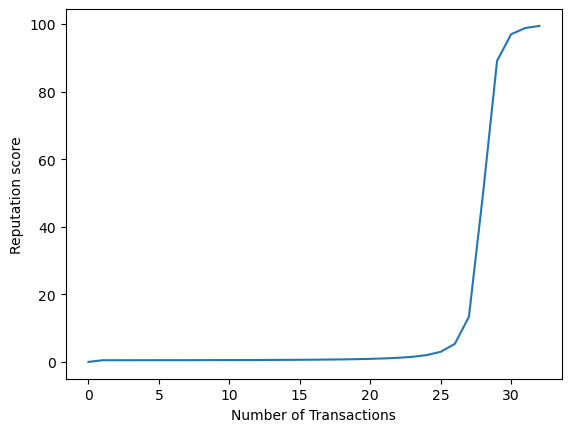

In [3]:
#declaring first time user parameters
user_age = 0
user_total_price_reviews = 0
total_reviews = 0
user_x = 1
user_rep = 0
price=2322070000000000.0 #5USD
# price = 443866700000000000.0 #1000USD
# price = 1000000000000000000.0 #2k USD
total_time_passed = 0.0
time_difference = 24.0

repList = []
xList = []
repList.append(0)
xList.append(0)

A_VALUE = 50 # remains the same
B_VALUE = 100
C_VALUE = 200
BETA1 = 0.99
BETA2 = 4000
count = 0

while user_rep < 99 and count<1000:
        total_time_passed += time_difference    
        user_x = calculateX_Buyer(user_x, time_difference, price, BETA1, BETA2)
        xList.append(user_x)
        user_rep = sigmoidal(user_x, A_VALUE, B_VALUE, C_VALUE)
        repList.append(user_rep)
        count += 1

        
print("Number of transactions needed: ", len(repList)-1)
print("Number of hours: ",(total_time_passed))
print("Number of days: ", (total_time_passed)/24)
print("Reputation Score: ", user_rep)


x = [i for i in range(len(repList))]
y = repList
plt.plot(x,y)
plt.xlabel("Number of Transactions")
plt.ylabel("Reputation score")

# Simulation 1: Can a user artificially inflate his reputation score within a short period of time? 


**Considerations**
1. If so, what is the tolerance?
2. How long before the reputation can be increased?

**Notes**
1. Here, the attacker spams review every hour. 
2. Different values of the hyperparameters are explored to choose the ones best to resist such attacks. 


**Hyperparameters**
1. B_VALUE
2. C_VALUE
3. BETA1
4. BETA2

In [4]:
df = pd.DataFrame(columns = ['B_VALUE', 'C_VALUE', 'BETA1', 'BETA2', 'transactions', 'ETH', 'hours', 'days', 'FinalScore'])

def sim1(b, c,b1, b2):
    #Variables to keep track of
    total_time_passed = 0.0
    user_x = 1
    user_rep = 0
    repList = []
    xList = []
    price =2322070000000000
    count = 0
    time_difference = 1.0
    while user_rep < 99 and count<1000:
        total_time_passed += time_difference    
        user_x = calculateX_Buyer(user_x, time_difference, price, b1, b2)
        xList.append(user_x)
        user_rep = sigmoidal(user_x, 50, b, c)
        repList.append(user_rep)
        count += 1
        
    return len(repList), (len(repList))*2322070000000000/(10**18), total_time_passed, total_time_passed/24, user_rep

#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 1000, 100):
    for c in range(100, 1000, 100):
        for b1 in [0.95, 0.96, 0.97, 0.98, 0.99]:
            for b2 in range(500, 5000, 500): 
                transactions, ETH, hours, days, user_rep = sim1(b, c, b1, b2)
                df.loc[len(df)] = [b, c, b1, b2, transactions, ETH, hours, days, user_rep]
    
df

,B_VALUE,C_VALUE,BETA1,BETA2,transactions,ETH,hours,days,FinalScore
0,100.0,100.0,0.95,500.0,1000.0,2.32207,1000.0,41.666667,0.248140
1,100.0,100.0,0.95,1000.0,1000.0,2.32207,1000.0,41.666667,0.248140
2,100.0,100.0,0.95,1500.0,1000.0,2.32207,1000.0,41.666667,0.248140
3,100.0,100.0,0.95,2000.0,1000.0,2.32207,1000.0,41.666667,0.248140
4,100.0,100.0,0.95,2500.0,1000.0,2.32207,1000.0,41.666667,0.248140
...,...,...,...,...,...,...,...,...,...
3640,900.0,900.0,0.99,2500.0,1000.0,2.32207,1000.0,41.666667,0.027755
3641,900.0,900.0,0.99,3000.0,1000.0,2.32207,1000.0,41.666667,0.027755
3642,900.0,900.0,0.99,3500.0,1000.0,2.32207,1000.0,41.666667,0.027755
3643,900.0,900.0,0.99,4000.0,1000.0,2.32207,1000.0,41.666667,0.027755


In [5]:
df.to_csv('Simulation_1_1Hour_New_Equation.csv')

# Simulation 2: Can a user artificially inflate his reputation score within a short period of time? 


**Considerations**
1. If so, what is the tolerance?
2. How long before the reputation can be increased?

**Notes**
1. Here, the attacker spams review every 24 hours. 
2. Different values of the hyperparameters are explored to choose the ones best to resist such attacks. 


**Hyperparameters**
1. B_VALUE
2. C_VALUE
3. BETA1
4. BETA2
5. BETA3
6. BETA4

In [6]:
df = pd.DataFrame(columns = ['B_VALUE', 'C_VALUE', 'BETA1', 'BETA2', 'transactions', 'ETH', 'hours', 'days', 'FinalScore'])

def sim2(b, c,b1, b2):
    #Variables to keep track of
    total_time_passed = 0.0
    user_x = 1
    user_rep = 0
    repList = []
    xList = []
    price =2322070000000000
    count = 0
    time_difference = 24.0
    while user_rep < 99 and count<1000:
        total_time_passed += time_difference 
        user_x = calculateX_Buyer(user_x, time_difference, price, b1, b2)
        xList.append(user_x)
        user_rep = sigmoidal(user_x, 50, b, c)
        repList.append(user_rep)
        count += 1
        
    return len(repList), (len(repList))*2322070000000000/(10**18), total_time_passed, total_time_passed/24, user_rep

#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 1000, 100):
    for c in range(100, 1000, 100):
        for b1 in [0.95, 0.96, 0.97, 0.98, 0.99]:
            for b2 in range(500, 5000, 500): 
                transactions, ETH, hours, days, user_rep = sim2(b, c, b1, b2)
                df.loc[len(df)] = [b, c, b1, b2, transactions, ETH, hours, days, user_rep]
                
df

,B_VALUE,C_VALUE,BETA1,BETA2,transactions,ETH,hours,days,FinalScore
0,100.0,100.0,0.95,500.0,15.0,0.034831,360.0,15.0,99.767214
1,100.0,100.0,0.95,1000.0,19.0,0.044119,456.0,19.0,99.365025
2,100.0,100.0,0.95,1500.0,23.0,0.053408,552.0,23.0,99.402770
3,100.0,100.0,0.95,2000.0,27.0,0.062696,648.0,27.0,99.590344
4,100.0,100.0,0.95,2500.0,30.0,0.069662,720.0,30.0,99.429643
...,...,...,...,...,...,...,...,...,...
3640,900.0,900.0,0.99,2500.0,35.0,0.081272,840.0,35.0,99.806265
3641,900.0,900.0,0.99,3000.0,38.0,0.088239,912.0,38.0,99.813804
3642,900.0,900.0,0.99,3500.0,40.0,0.092883,960.0,40.0,99.397920
3643,900.0,900.0,0.99,4000.0,43.0,0.099849,1032.0,43.0,99.709568


In [7]:
df.to_csv("Simulation_2_24Hour_New_Equation.csv")

# Simulation 3: Can a user artificially inflate his reputation score within a short period of time? 


**Considerations**
1. If so, what is the tolerance?
2. How long before the reputation can be increased?

**Notes**
1. Here, the attacker spams review at random time intervals
2. Different values of the hyperparameters are explored to choose the ones best to resist such attacks. 


**Hyperparameters**
1. B_VALUE
2. C_VALUE
3. BETA1
4. BETA2
5. BETA3
6. BETA4

In [8]:
df = pd.DataFrame(columns = ['B_VALUE', 'C_VALUE', 'BETA1', 'BETA2', 'transactions', 'ETH', 'hours', 'days', 'FinalScore'])
rand_list = []
for i in range(10000):
    rand_list.append(np.random.randint(0, 168))
rowV=0

def sim3(b, c,b1, b2, rowV):
    #Variables to keep track of
    total_time_passed = 0.0
    user_x = 1
    user_rep = 0
    repList = []
    xList = []
    price =2322070000000000
    count = 0
    time_difference = rand_list[rowV]
    while user_rep < 99 and count<10000:
        total_time_passed += time_difference
        user_x = calculateX_Buyer(user_x, time_difference, price, b1, b2)
        xList.append(user_x)
        user_rep = sigmoidal(user_x, 50, b, c)
        repList.append(user_rep)
        count +=1
        
    return len(repList), (len(repList))*2322070000000000/(10**18), total_time_passed, total_time_passed/24, user_rep

#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 1000, 100):
    for c in range(100, 1000, 100):
        for b1 in [0.95, 0.96, 0.97, 0.98, 0.99]:
            for b2 in range(500, 5000, 500): 
                transactions, ETH, hours, days, user_rep = sim3(b, c, b1, b2, rowV)
                df.loc[len(df)] = [b, c, b1, b2, transactions, ETH, hours, days, user_rep]
                rowV += 1
    
df

,B_VALUE,C_VALUE,BETA1,BETA2,transactions,ETH,hours,days,FinalScore
0,100.0,100.0,0.95,500.0,9.0,0.020899,702.0,29.250,99.775709
1,100.0,100.0,0.95,1000.0,9.0,0.020899,846.0,35.250,99.702453
2,100.0,100.0,0.95,1500.0,21.0,0.048763,525.0,21.875,99.121699
3,100.0,100.0,0.95,2000.0,10000.0,23.220700,60000.0,2500.000,0.248140
4,100.0,100.0,0.95,2500.0,16.0,0.037153,576.0,24.000,99.644584
...,...,...,...,...,...,...,...,...,...
3640,900.0,900.0,0.99,2500.0,12.0,0.027865,1200.0,50.000,99.920907
3641,900.0,900.0,0.99,3000.0,21.0,0.048763,777.0,32.375,99.867558
3642,900.0,900.0,0.99,3500.0,12.0,0.027865,1608.0,67.000,99.958934
3643,900.0,900.0,0.99,4000.0,12.0,0.027865,2004.0,83.500,99.973717


In [9]:
df.to_csv("Simulation_3_Arbitrary_Time_New_Equation.csv")

# Simulation 4: Can a user create multiple different accounts, to influence reviews? (spam attack with un trusted users)

**Considerations**
1. How tolerant is the system?
2. How many accounts is needed before you can significantly increase? Each account creates one transaction/review --> number of accounts == number of transactions


**Others**
1. Values `B_VALUE_S`, `C_VALUE_S`, `BETA_S1`, `BETA_S2` are chosen arbitrarily


In [10]:
# For the buyers we set 
A_VALUE = 50 # remains the same
B_VALUE = 5
C_VALUE = 95

A_VALUE_S = 50 # remains the same
B_VALUE_S = 500 #can be fine tuned
C_VALUE_S = 1000 #can be fine tuned


BETA1 = 0.99
BETA2 = 5000
BETA_S = 0.1 #the smaller, means the lower the tolerance for deviation

Total Transactions need to reach review score 99:  10000
Minimum Expenditure (ETH):  23.2207
Final Review score:  0.10009979970059812


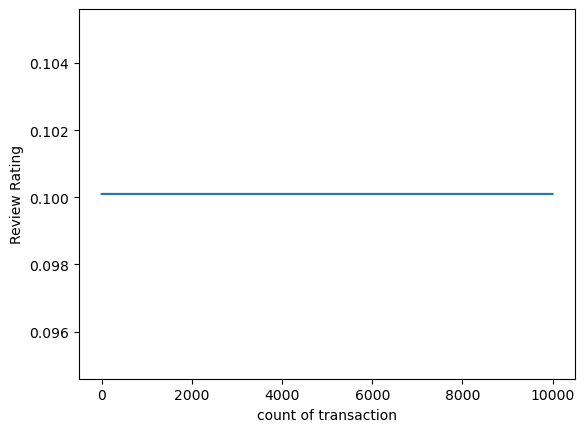

In [11]:
AVG_REVIEW = 1 #start 
OLD_X = 1 #start
R_INCOMING = 100
REP_SCORE = 0
review_list = []
count = 0

while count<10000 and AVG_REVIEW<99:
    count += 1
    X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
    AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
    OLD_X = X
    review_list.append(AVG_REVIEW)
    
x = [i for i in range(len(review_list))]
y = review_list
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Review Rating")
print("Total Transactions need to reach review score 99: ", len(review_list))
print("Minimum Expenditure (ETH): ", (len(review_list))*2322070000000000/(10**18))
print("Final Review score: ", AVG_REVIEW)

# Simulation 5: Can a user create multiple different accounts, to influence reviews? (spam attack with fully trusted users)

**Considerations**
1. How tolerant is the system?
2. How many transactions are needed before you can significantly increase?
3. What parameters can we set?

**Notes**
1. Hyperparameters are chosen arbitrarily, simply to see

Total Transactions need to reach review score 99:  62
Minimum Expenditure (ETH):  0.14396834
Last review score:  [99.37896426584294]
[0, 0.49800532703343503, 0.49854836939530744, 0.4991467346646683, 0.4998061722892466, 0.5005330532800667, 0.5013344424927901, 0.5022181803766734, 0.503192975646527, 0.5042685105993094, 0.5054555611191447, 0.5067661338073293, 0.5082136231540357, 0.5098129922584405, 0.5115809813318883, 0.5135363491216516, 0.5157001535175176, 0.5180960790125477, 0.5207508204635947, 0.523694534843866, 0.5269613755423175, 0.5305901274332225, 0.5346249656734414, 0.5391163673343635, 0.5441222130246282, 0.5497091262742282, 0.5559541125659484, 0.5629465788333898, 0.5707908398778161, 0.579609253203911, 0.5895461722035034, 0.6007729752939395, 0.6134945243472079, 0.6279575429242845, 0.6444616041770934, 0.663373712386478, 0.6851479031821262, 0.7103519608689157, 0.7397043994765873, 0.7741265208568049, 0.8148170760563456, 0.8633615875610956, 0.9218961789873192, 0.9933595830110331, 1.081

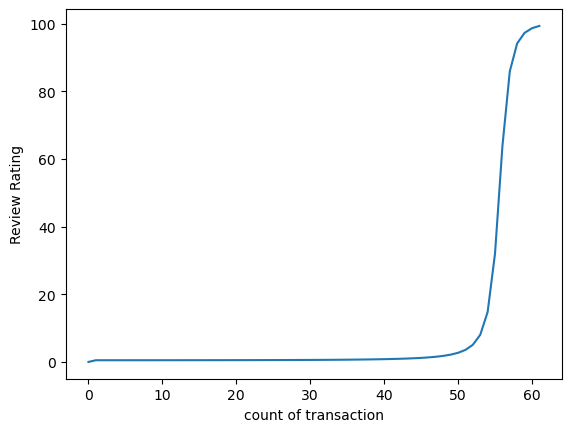

In [12]:
A_VALUE_S = 50 # remains the same
B_VALUE_S = 200 
C_VALUE_S = 800
BETA_S = 1
AVG_REVIEW = 0 #start 
OLD_X = 1 #start
R_INCOMING = 100
REP_SCORE = 99
review_list = []
count = 0
review_list.append(AVG_REVIEW)
while count<1000000000 and AVG_REVIEW<99:
    count += 1
    X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
    AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
    OLD_X = X
    review_list.append(AVG_REVIEW)
    
x = [i for i in range(len(review_list))]
y = review_list
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Review Rating")
print("Total Transactions need to reach review score 99: ", len(review_list))
print("Minimum Expenditure (ETH): ", (len(review_list))*2322070000000000/(10**18))
print("Last review score: ", review_list[-1:])
print(review_list)

# Simulation 6: Can a user create multiple different accounts, to influence reviews? (spam attack with fully trusted users)

**Considerations**
1. How tolerant is the system?
2. How many transactions are needed before you can significantly increase?
3. What parameters can we set?

**Notes**
1. Various values of hyperparameters are tested to see which will be most resistant

In [13]:
df = pd.DataFrame(columns = ['B_VALUE', 'C_VALUE', 'BETA_S','transactions','ETH', 'FinalReview'])

def sim6(A_VALUE_S, B_VALUE_S, C_VALUE_S, BETA_S):
    #Variables to keep track of
    AVG_REVIEW = 0 #start 
    OLD_X = 1 #start
    R_INCOMING = 100
    REP_SCORE = 99
    review_list = []
    count = 0
    review_list.append(AVG_REVIEW)

    while count<1000000000 and AVG_REVIEW<99:
        count += 1
        X = calculateX_Seller(OLD_X, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
        AVG_REVIEW = sigmoidal(X, A_VALUE_S, B_VALUE_S, C_VALUE_S)
        OLD_X = X
        review_list.append(AVG_REVIEW)
    
    return len(review_list), AVG_REVIEW


#the user tries to inflate within a month and price 100wei, time between transactions is one hour
for b in range(100, 500, 100):
    for c in range(100, 1000, 100):
        for beta_s in [0.1, 1, 10]:
                transactions, review = sim6(50, b, c, beta_s)
                df.loc[len(df)] = [b, c, beta_s, transactions, transactions*2322070000000000/(10**18), review]
    
df

,B_VALUE,C_VALUE,BETA_S,transactions,ETH,FinalReview
0,100.0,100.0,0.1,54.0,0.125392,99.059797
1,100.0,100.0,1.0,53.0,0.123070,99.020771
2,100.0,100.0,10.0,48.0,0.111459,99.158423
3,100.0,200.0,0.1,56.0,0.130036,99.303700
4,100.0,200.0,1.0,55.0,0.127714,99.500509
...,...,...,...,...,...,...
103,400.0,800.0,1.0,67.0,0.155579,99.321199
104,400.0,800.0,10.0,61.0,0.141646,99.301092
105,400.0,900.0,0.1,68.0,0.157901,99.201841
106,400.0,900.0,1.0,67.0,0.155579,99.207968


In [14]:
df.to_csv("Simulation_6_Seller_New_Equation.csv")

# Simulation 8(NA): Can a user create multiple different accounts, to influence reviews? (spam attack with mixed time gaps with low reputation score)

**Considerations**
1. How tolerant is the system?
2. How many accounts is needed before you can significantly increase?
3. What parameters can we set?

This simulation was taken from the senior's report. However, this is not possible in this version. First of all, using the same account, is the same as using multiple different accounts. This is because the reputation score is not negatively affected. 

# Simulation 9(NA): Can a user create multiple different accounts, to influence reviews? (spam attack with only long time durations between the attacks)

**Considerations**
1. How tolerant is the system?
2. How many accounts is needed before you can significantly increase?
3. What parameters can we set?

This simulation was taken from the senior's report. However, this is not possible in this version. First of all, using the same account, is the same as using multiple different accounts. This is because the reputation score is not negatively affected. 

# Simulation 7: Can we use the same account, starting with no reputation, to gain reputation and leave a review?

**Considerations**
1. How tolerant is the system?
2. How many transactions is needed?

We know that we cannot deviate too far from the rating to affect the product rating. We also know we cannot have too much time in between the transaction. Additionally, we need to reduce the cost as much as possible for the attack. 

Let us say for each review left by the user, they receive a reward. Let us say they receive 10% of the product price multiplied by their reputation score. 

In [15]:
A_VALUE = 50 # remains the same
B_VALUE = 100 
C_VALUE = 300

A_VALUE_S = 50 # remains the same
B_VALUE_S = 300 
C_VALUE_S = 900

BETA_S = 1
BETA_1 = 0.99
BETA_2 = 4000

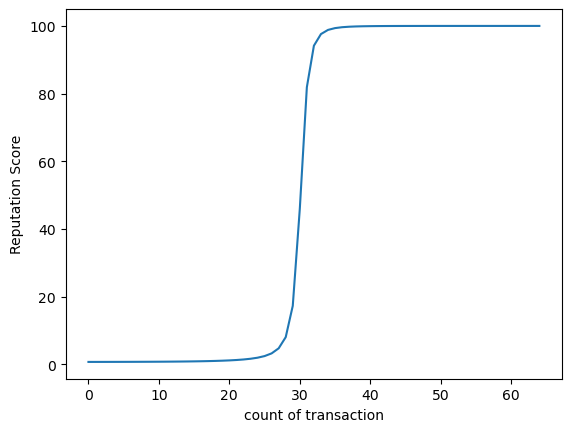

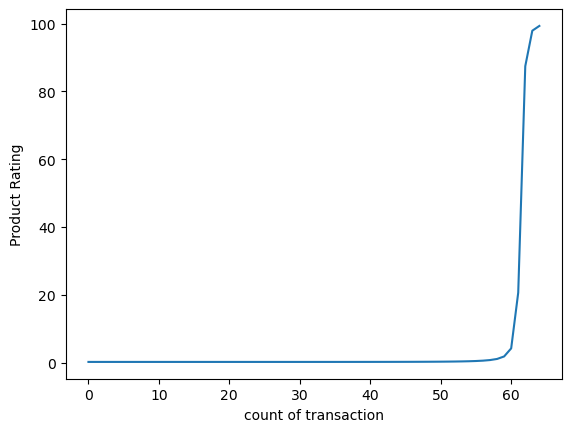

Final Reputation Score:  99.99996695208885
Final Rating:  99.32594030766182
Total Transactions needed:  65
Total number of days:  65.0
Total Cost of Purchasing Product:  0.15093455
Total Reward Obtained:  0.00807447546892312
Net Gain/Loss:  0.14286007453107688
Net Gain in USD:  301.8610255245311


In [16]:
AVG_REVIEW = 0
X_SELLER = 1
REP_SCORE = 0
X_BUYER = 1
R_INCOMING = 0
PRICE = 2322070000000000
AVG_REVIEW_LIST = []
REP_SCORE_LIST = []
TOTAL_REWARD = 0
TIMEDIFF = 24

count = 0
while AVG_REVIEW<99 and count<10000:
#     print("Seller X: ", X_SELLER)
#     print("Seller Review: ", AVG_REVIEW)
#     print("Buyer X: ", X_BUYER)
#     print("Buyer Reputation: ", REP_SCORE)
#     print("..................")
    
    # give the seller the review 
    X_SELLER = calculateX_Seller(X_SELLER, REP_SCORE, R_INCOMING, AVG_REVIEW, BETA_S)
    AVG_REVIEW = sigmoidal(X_SELLER, A_VALUE_S, B_VALUE_S, C_VALUE_S)
    AVG_REVIEW_LIST.append(AVG_REVIEW)
    
        
    X_BUYER = calculateX_Buyer(X_BUYER, TIMEDIFF, PRICE, BETA1, BETA2)
    REP_SCORE = sigmoidal(X_BUYER, A_VALUE, B_VALUE, C_VALUE)
    REP_SCORE_LIST.append(REP_SCORE)
    TOTAL_REWARD += 0.10 * PRICE * REP_SCORE/100
    
    R_INCOMING = AVG_REVIEW + 1 
    count += 1
    
    

x = [i for i in range(len(REP_SCORE_LIST))]
y = REP_SCORE_LIST
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Reputation Score")    
plt.show()
    
x = [i for i in range(len(AVG_REVIEW_LIST))]
y = AVG_REVIEW_LIST
plt.plot(x,y)
plt.xlabel("count of transaction")
plt.ylabel("Product Rating")    
plt.show()

print("Final Reputation Score: ", REP_SCORE)
print("Final Rating: ", AVG_REVIEW)
print("Total Transactions needed: ", count)
print("Total number of days: ", count*TIMEDIFF/24)
print("Total Cost of Purchasing Product: ", PRICE*count/(10**18))
print("Total Reward Obtained: ", TOTAL_REWARD/(10**18))
print("Net Gain/Loss: ", PRICE*count/(10**18)-TOTAL_REWARD/(10**18))
print("Net Gain in USD: ", 2000*PRICE*count/(10**18)-TOTAL_REWARD/(10**18))